<a href="https://colab.research.google.com/github/BrendaG04/Google1D/blob/main/notebooks/RU_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🇷🇺 RUSSIA YouTube Trending EDA

**Outline**
1. Setup & Paths  
2. Load & Normalize Columns  
3. Feature Understanding  
4. Univariate Analysis  
5. Bivariate/Multivariate  
6. Temporal Analysis  
7. Text Analysis (titles/tags)  
8. Outliers (IQR)  
9. Save Processed Snapshot  
10. Summary & Next Steps


##  1. Setup & Paths
Configure the environment, import required libraries, and set up local folders for raw and processed data.


In [13]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re
from collections import Counter

# Setup display options
pd.set_option('display.max_columns', None)
plt.style.use("seaborn-v0_8-whitegrid")

# Define data paths
DATA_ROOT = Path("../data-local")
RAW = DATA_ROOT / "raw"
PROC = DATA_ROOT / "processed"
RAW.mkdir(parents=True, exist_ok=True)
PROC.mkdir(parents=True, exist_ok=True)

# RU dataset path
RU_CSV = RAW / "RU_youtube_trending_data.csv"
assert RU_CSV.exists(), f"❌ File not found: {RU_CSV}"
print("✅ Data file found at:", RU_CSV)


✅ Data file found at: ../data-local/raw/RU_youtube_trending_data.csv


## 2. Load & Data Cleaning
We load the dataset, inspect its structure, handle missing values, fix data types, and clean invalid rows for accurate EDA.



In [14]:
# Load dataset
df = pd.read_csv(RU_CSV)
print("Initial shape:", df.shape)
display(df.head(3))

# Drop duplicates
if "video_id" in df.columns:
    before = len(df)
    df.drop_duplicates(subset="video_id", inplace=True)
    print(f"🧹 Removed {before - len(df)} duplicate rows")

# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
obj_cols = df.select_dtypes(include="object").columns

df[num_cols] = df[num_cols].fillna(0)
df[obj_cols] = df[obj_cols].fillna("Unknown")

# Convert date columns
for c in ["publish_time", "publishedAt", "trending_date"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Remove invalid or zero-view rows
if "views" in df.columns:
    df = df[df["views"] > 0]

# Clean text
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

print("✅ Cleaned shape:", df.shape)
display(df.isna().sum().sort_values(ascending=False).head(10))


Initial shape: (238637, 16)


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,e_Z6upbeYuc,Побег Из КАРТОННОЙ ТЮРЬМЫ Челлендж **2 часть**,2020-08-12T09:00:16Z,UC2tsySbe9TNrI-xh2lximHA,A4,24,2020-08-12T00:00:00Z,Побег Из КАРТОННОЙ ТЮРЬМЫ Челлендж **2 часть**...,5173063,1052986,29927,63557,https://i.ytimg.com/vi/e_Z6upbeYuc/default.jpg,False,False,Новые кроссовки Reebok Classic Leather Legacy ...
1,X5j69JMlbwM,DAVA & Филипп Киркоров – РОЛЕКС (Премьера клип...,2020-08-12T09:00:10Z,UCbh7BxJWCMnWLwJ-traa6Wg,DAVA,22,2020-08-12T00:00:00Z,РОЛЕКС|DAVA|Киркоров|2020|музыка в машину|музы...,636749,58770,28133,5051,https://i.ytimg.com/vi/X5j69JMlbwM/default.jpg,False,False,#Dava #ФилиппКиркоров #Ролекс #Music С огромны...
2,FzJjlIzZlVc,Как Я ЧУТЬ НЕ УМЕР 2 (анимация),2020-08-12T10:00:02Z,UCLNrn6a4Co8D6H7jRZtNPcA,X2DED,1,2020-08-12T00:00:00Z,как я чуть не умер|чуть не умер|история из жиз...,359904,45025,438,2793,https://i.ytimg.com/vi/FzJjlIzZlVc/default.jpg,False,False,Это история анимация о том как я чуть не умер ...


🧹 Removed 107381 duplicate rows
✅ Cleaned shape: (131256, 16)


video_id         0
title            0
publishedAt      0
channelId        0
channelTitle     0
categoryId       0
trending_date    0
tags             0
view_count       0
likes            0
dtype: int64

##  3. Feature Understanding

We check data types, missing values, and unique entries to understand the dataset structure and feature coverage.


In [4]:
# -------- 3) FEATURE UNDERSTANDING --------
print("dtypes:")
print(df.dtypes)

print("\nMissing values:")
display(df.isna().sum().sort_values(ascending=False).head(20))

print("\nUnique counts:")
display(df.nunique(dropna=True).sort_values().head(20))

print("\nNumeric summary:")
display(df[NUM_COLS].describe().T if NUM_COLS else "No numeric columns detected.")

print("\nTop categories/channels (if present):")
if "category_id" in df.columns:
    display(df["category_id"].value_counts().head(10))
if "channel_title" in df.columns:
    display(df["channel_title"].value_counts().head(10))


dtypes:
video_id             object
title                object
publishedAt          object
channelId            object
channelTitle         object
categoryId            int64
trending_date        object
tags                 object
view_count            int64
likes                 int64
dislikes              int64
comment_count         int64
thumbnail_link       object
comments_disabled      bool
ratings_disabled       bool
description          object
channel_title        object
category_id           int64
comments              int64
publish_time         object
dtype: object

Missing values:


description          16978
video_id                 0
title                    0
comments                 0
category_id              0
channel_title            0
ratings_disabled         0
comments_disabled        0
thumbnail_link           0
comment_count            0
dislikes                 0
likes                    0
view_count               0
tags                     0
trending_date            0
categoryId               0
channelTitle             0
channelId                0
publishedAt              0
publish_time             0
dtype: int64


Unique counts:


ratings_disabled          2
comments_disabled         2
category_id              15
categoryId               15
trending_date          1323
channelId              8058
channel_title          8482
channelTitle           8482
dislikes               9084
comments              20151
comment_count         20151
tags                  84278
likes                 85471
description          111625
publish_time         129456
publishedAt          129456
title                130947
video_id             131256
thumbnail_link       131260
view_count           208504
dtype: int64


Numeric summary:


,count,mean,std,min,25%,50%,75%,max
likes,238637.0,54786.834338,221043.390384,0.0,5242.0,14203.0,40076.0,14678180.0
dislikes,238637.0,596.981889,4681.298356,0.0,0.0,0.0,228.0,778804.0
comments,238637.0,4031.519961,42652.731361,0.0,279.0,861.0,2296.0,5987787.0



Top categories/channels (if present):


category_id
22    42514
24    37911
20    33882
25    29045
17    16439
23    15430
10    15136
1     15038
2     12829
28     5710
Name: count, dtype: int64

channel_title
A4                                 1767
Телеканал Дождь                    1619
Матч ТВ                            1484
EdisonPts                          1368
MrLololoshka (Роман Фильченков)    1248
Анатолий Шарий                     1127
Россия 24                          1079
Соловьёв LIVE                       988
LeBwa                               947
ФЕЙГИН LIVE                         869
Name: count, dtype: int64

## 4. Univariate Analysis
In this section, we visualize and summarize single variables to observe distributions, ranges, and outliers.  
We focus on metrics like `views`, `likes`, `comments`, and engagement ratios to identify key behavioral patterns.

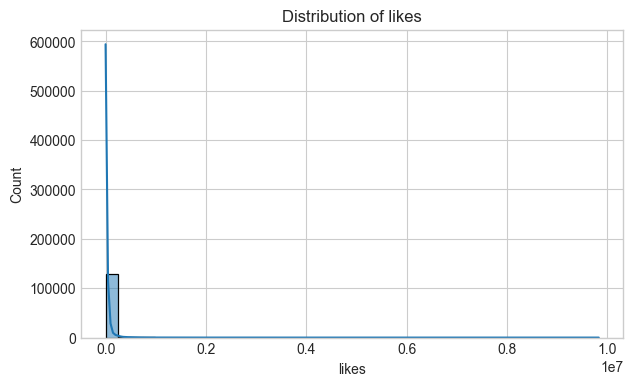

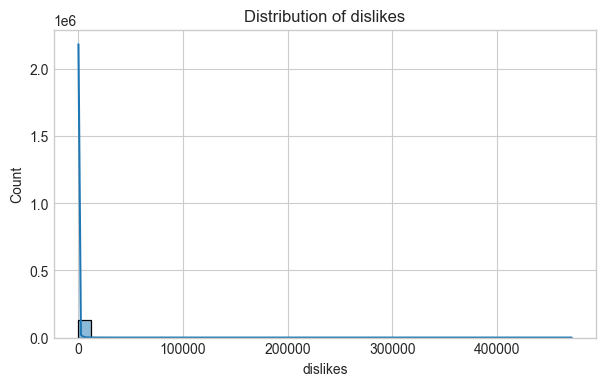

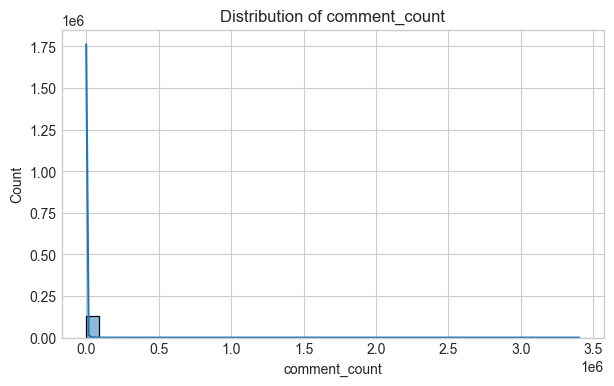

,likes,dislikes,comment_count
count,1.312560e+05,131256.000000,1.312560e+05
mean,3.522797e+04,347.895913,2.543841e+03
std,1.273486e+05,2297.814700,2.044658e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,4.012000e+03,0.000000,2.190000e+02
50%,1.038300e+04,0.000000,6.790000e+02
75%,2.746900e+04,201.000000,1.754000e+03
max,9.825911e+06,471525.000000,3.403157e+06


In [15]:
numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
numeric_cols = [c for c in numeric_cols if c in df.columns]

for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

df[numeric_cols].describe()


##  5. Bivariate / Multivariate Analysis
Next, we explore relationships between variables such as `views` vs `likes` or `views` vs `comments`.  
This helps reveal how engagement metrics interact and which features correlate with potential virality.

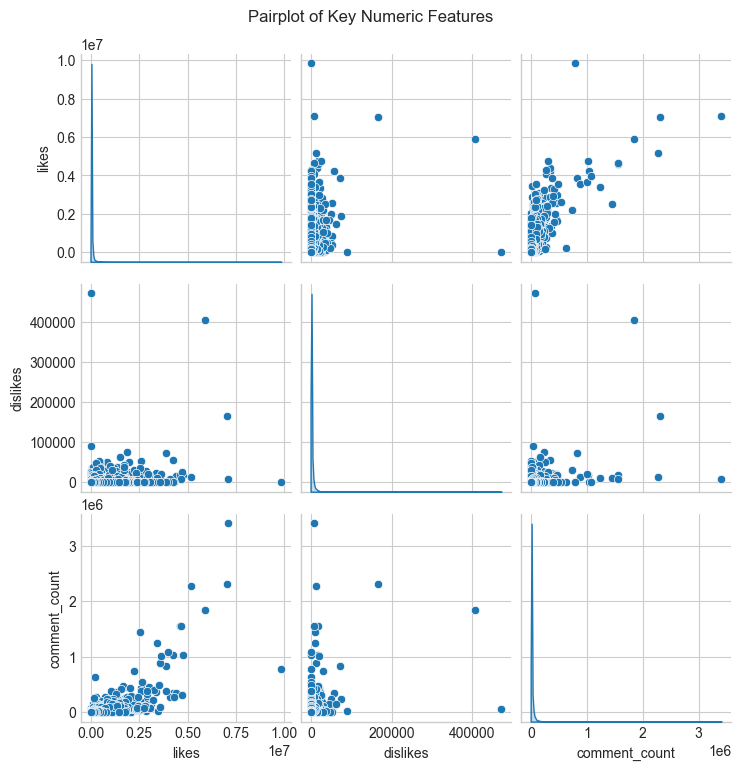

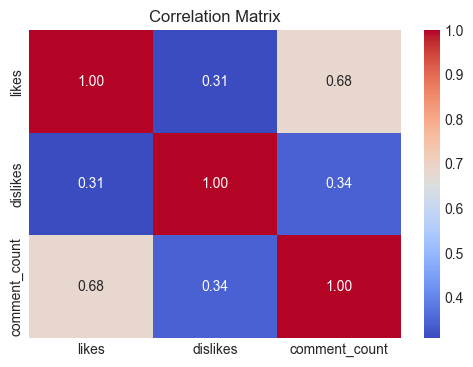

In [16]:
sns.pairplot(df[numeric_cols], diag_kind="kde")
plt.suptitle("Pairplot of Key Numeric Features", y=1.02)
plt.show()

corr = df[numeric_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


##  6. Temporal Analysis
We examine time-based patterns such as publish hours, trending frequency, and average engagement by date.  
This step helps determine if certain upload times or days of the week contribute to higher visibility.

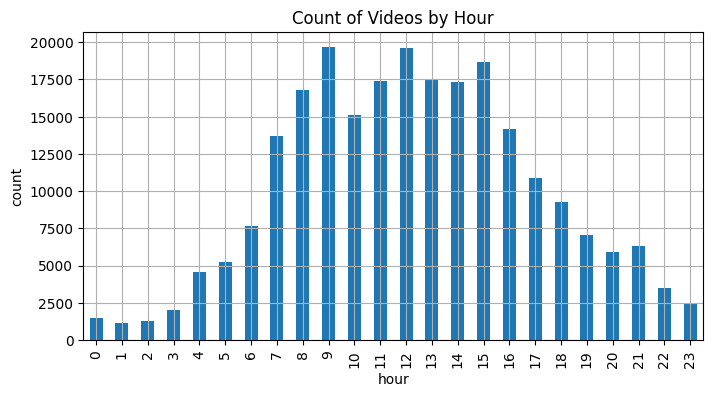

In [7]:
# -------- 6) TEMPORAL --------
def to_dt(col):
    if col in df.columns:
        return pd.to_datetime(df[col], errors="coerce", utc=True)
    return None

dt_col = None
for c in ["publish_time","trending_time"]:
    dt = to_dt(c)
    if dt is not None:
        dt_col = c + "_dt"
        df[dt_col] = dt
        break

if dt_col:
    df["date"] = df[dt_col].dt.date
    df["hour"] = df[dt_col].dt.hour
    df["dow"]  = df[dt_col].dt.dayofweek

    by_day = df.groupby("date")["views"].mean().dropna() if "views" in df.columns else None
    if by_day is not None and not by_day.empty:
        plt.figure(); by_day.plot()
        plt.title("Average Views by Day"); plt.ylabel("avg views"); plt.xlabel("date")
        plt.show()

    if "hour" in df.columns:
        plt.figure()
        df["hour"].dropna().astype(int).value_counts().sort_index().plot(kind="bar")
        plt.title("Count of Videos by Hour"); plt.xlabel("hour"); plt.ylabel("count")
        plt.show()
else:
    print("No datetime column available; skipped temporal analysis.")


## 7. Text Analysis (Titles & Tags)
Here, we extract and analyze frequent words in video titles and tags to uncover linguistic or thematic trends.  
Textual insights can help identify what types of content resonate most with viewers in the Russian dataset.

In [8]:
# -------- 7) TEXT ANALYSIS --------
title_col = next((c for c in ["title","Title","video_title"] if c in df.columns), None)
tags_col  = next((c for c in ["tags","Tags"] if c in df.columns), None)

def top_words(series, k=20):
    if series is None: return pd.DataFrame()
    text = " ".join(map(str, series.dropna().astype(str).values))
    toks = re.findall(r"[A-Za-zА-Яа-я0-9']+", text.lower())
    toks = [t for t in toks if len(t) >= 3]
    return pd.DataFrame(Counter(toks).most_common(k), columns=["token","count"])

if title_col:
    display(top_words(df[title_col], 25).head(25).style.bar(subset=["count"], color="#bcd"))

if tags_col:
    cleaned = df[tags_col].astype(str).str.replace(r'[\[\]"]', "", regex=True).str.replace("|", ",")
    display(top_words(cleaned, 25).head(25).style.bar(subset=["count"], color="#bcd"))

,token,count
0,2021,11482
1,как,9948
2,что,9738
3,shorts,9022
4,майнкрафт,6534
5,2022,5884
6,обзор,5490
7,2020,5173
8,это,5043
9,the,4883


,token,count
0,новости,53588
1,майнкрафт,41300
2,обзор,37338
3,none,35550
4,как,30947
5,2021,26980
6,россия,26952
7,челлендж,26302
8,онлайн,23447
9,шоу,22135


##  8. Outlier Detection
We identify statistical outliers in numeric columns using the Interquartile Range (IQR) method.  
Outliers can highlight exceptional videos with unusually high engagement or potential anomalies in the data.

likes: 27054 outliers (lo=-47,009, hi=92,327)


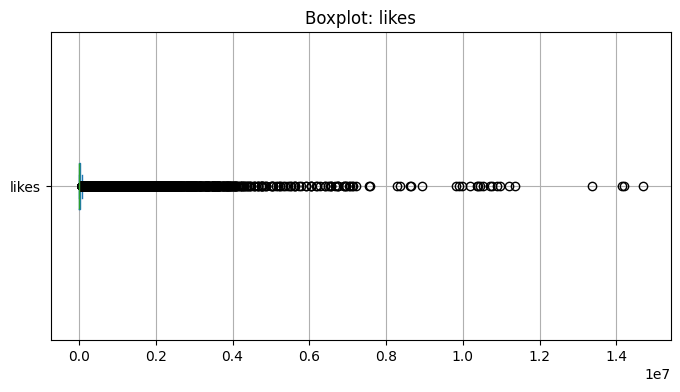

comments: 25676 outliers (lo=-2,746, hi=5,322)


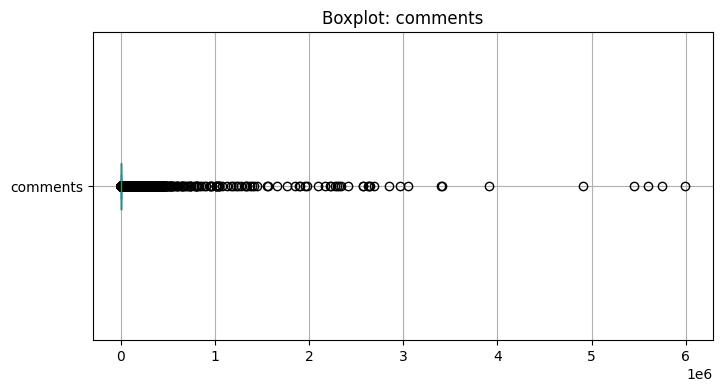

In [9]:
# -------- 8) OUTLIERS (IQR) --------
def iqr_bounds(s: pd.Series):
    s = s.dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - 1.5*iqr
    hi = q3 + 1.5*iqr
    return lo, hi

for c in [x for x in ["views","likes","comments"] if x in df.columns]:
    lo, hi = iqr_bounds(df[c])
    outs = df[(df[c] < lo) | (df[c] > hi)]
    print(f"{c}: {len(outs)} outliers (lo={lo:,.0f}, hi={hi:,.0f})")
    plt.figure(); df[c].plot(kind="box", vert=False); plt.title(f"Boxplot: {c}"); plt.show()


## 9. Save Processed Snapshot
We save a processed version of the dataset in Parquet format for faster reloading in future analysis steps.  
This ensures reproducibility and efficient access during model development.

In [10]:
# -------- 9) SAVE PROCESSED SNAPSHOT --------
out_path = PROC / "RU.parquet"
df.to_parquet(out_path, index=False)
print("Saved:", out_path)

Saved: /Users/kristel7777/Google1D/data-local/processed/RU.parquet


## 10. Summary & Next Steps
We wrap up with a concise summary of findings and correlations, followed by notes on future modeling directions.  
Next steps may include feature engineering, predictive modeling, or comparative analysis with other regions.

In [11]:
# -------- 10) SUMMARY --------
summary = {
    "rows": int(df.shape[0]),
    "cols": int(df.shape[1]),
    "num_cols": NUM_COLS,
    "cat_cols": CAT_COLS,
}

if len(NUM_COLS) >= 2:
    top_corr = (
        df[NUM_COLS].corr(numeric_only=True)
          .stack()
          .dropna()
          .sort_values(ascending=False)
          .drop_duplicates()
          .head(5)
          .to_dict()
    )
    summary["top_corr_pairs"] = {str(k): float(v) for k, v in top_corr.items()}

print(json.dumps(summary, indent=2, ensure_ascii=False))


{
  "rows": 238637,
  "cols": 24,
  "num_cols": [
    "likes",
    "dislikes",
    "comments"
  ],
  "cat_cols": [
    "channel_title",
    "category_id"
  ],
  "top_corr_pairs": {
    "('likes', 'likes')": 1.0,
    "('likes', 'comments')": 0.7068996980019622,
    "('dislikes', 'comments')": 0.4604911847030305,
    "('likes', 'dislikes')": 0.3980122435168895
  }
}
